In [26]:
# predict_time_waited.py
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



In [2]:
# -----------------------
# 0) Config
# -----------------------
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
DATA_PATH = os.path.join(data_folder, "trials_training_filtered2.csv")   # change if needed
TARGET = "time_waited"

# Features you specified (normalized to straight quotes & stripped)
FEATURES = [
    "session_trial_num", "block_trial_num", "block_num",
    "bg_drawn", "bg_length", "bg_repeats", "num_bg_licks", "first_lick",
    "time_since_last_reward", "cumulative_reward",
    "mouse", "session", "running_reward_rate",
    "previous_trial_reward_outcome", "group"
]

FEATURES = ["group"]
# Which columns should be treated as categorical?
CATEGORICAL = ["mouse", "session", "previous_trial_reward_outcome", "group"]
NUMERIC = [c for c in FEATURES if c not in CATEGORICAL]

# Evaluation modes: "random", "by_session", "by_mouse"
EVAL_MODES = ["random", "by_session", "by_mouse"]

# Output files
OUT_METRICS_CSV = "model_metrics.csv"
OUT_IMPORTANCE_CSV = "feature_importance.csv"

# Random state
RNG = 42


In [3]:

# -----------------------
# 1) Utilities
# -----------------------
# def sanitize_columns(df: pd.DataFrame) -> pd.DataFrame:
#     """Fix curly quotes/spaces and ensure required columns exist."""
#     # Normalize column names: strip spaces, replace fancy quotes with ASCII
#     mapping = {c: (c.replace("’", "'").replace("`", "'").strip()) for c in df.columns}
#     df = df.rename(columns=mapping)
#     # Also fix any stray spaces in FEATURES
#     global FEATURES, CATEGORICAL, NUMERIC
#     FEATURES = [f.replace("’", "'").replace("`", "'").strip() for f in FEATURES]
#     CATEGORICAL = [f.replace("’", "'").replace("`", "'").strip() for f in CATEGORICAL]
#     NUMERIC = [f for f in FEATURES if f not in CATEGORICAL]
#     # Quick check
#     missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
#     if missing:
#         raise ValueError(f"Missing columns in CSV: {missing}")
#     return df

def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return dict(r2=r2, mae=mae, rmse=rmse)


def get_feature_names_from_ct(ct: ColumnTransformer) -> list:
    """
    Retrieve transformed feature names from a ColumnTransformer.
    Works for OneHotEncoder/OrdinalEncoder + passthrough/scalers.
    """
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(transformer, "named_steps"):
            # Pipeline inside ColumnTransformer
            last = list(transformer.named_steps.values())[-1]
        else:
            last = transformer

        if isinstance(last, OneHotEncoder):
            # Detailed names
            ohe_names = last.get_feature_names_out(cols)
            feature_names.extend(ohe_names)
        elif hasattr(last, "get_feature_names_out"):
            try:
                feature_names.extend(last.get_feature_names_out(cols))
            except:
                feature_names.extend(cols)
        else:
            # No name expansion
            feature_names.extend(cols)
    return list(feature_names)

# -----------------------
# 2) Build pipelines
# -----------------------
def make_linear_pipeline():
    """
    L1-regularized linear regression (Lasso) with:
      - Numeric: StandardScaler
      - Categorical: OneHotEncoder (min_frequency reduces huge one-hot explosions)
    """
    numeric_pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True))
    ])
    categorical_pipe = OneHotEncoder(
        handle_unknown="infrequent_if_exist",
        min_frequency=20,   # collapse rare categories
        sparse_output=False
    )

    preproc = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, NUMERIC),
            ("cat", categorical_pipe, CATEGORICAL)
        ],
        remainder="drop"
    )
    model = Lasso(alpha=0.05, random_state=RNG, max_iter=10000)
    pipe = Pipeline([
        ("preproc", preproc),
        ("model", model)
    ])
    return pipe

def make_rf_pipeline():
    """
    RandomForest with:
      - Numeric: passthrough
      - Categorical: OrdinalEncoder (unknown -> -1).
    Trees handle ordinal codes fine and avoid huge one-hots.
    """
    categorical_pipe = OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    )
    preproc = ColumnTransformer(
        transformers=[
            ("num", "passthrough", NUMERIC),
            ("cat", categorical_pipe, CATEGORICAL)
        ],
        remainder="drop"
    )
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=RNG
    )
    pipe = Pipeline([
        ("preproc", preproc),
        ("model", rf)
    ])
    return pipe

# -----------------------
# 3) Evaluation modes
# -----------------------


def evaluate_group_cv(df, group_col, model_name, pipe, n_splits=5):
    """
    Leave-groups-out style evaluation with GroupKFold:
      - group_col = 'session' or 'mouse'
    Aggregates metrics across folds and computes permutation importance on the last fold.
    """
    X = df[FEATURES]
    y = df[TARGET]
    groups = df[group_col].astype(str).values
    gkf = GroupKFold(n_splits=min(n_splits, len(np.unique(groups))))
    fold_metrics = []
    last_perm_df = None

    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        pipe_fold = make_linear_pipeline() if model_name == "lasso" else make_rf_pipeline()
        pipe_fold.fit(X_tr, y_tr)
        y_pred = pipe_fold.predict(X_te)
        m = compute_metrics(y_te, y_pred)
        m["fold"] = fold_idx + 1
        fold_metrics.append(m)

        # Permutation importance on one representative fold
        if fold_idx == 0:
            preproc = pipe_fold.named_steps["preproc"]
            feat_names = get_feature_names_from_ct(preproc)
            perm = permutation_importance(pipe_fold, X_te, y_te, n_repeats=10, random_state=RNG, n_jobs=-1)
            last_perm_df = summarize_permutation_importance(perm, feat_names, top_k=50)

    metrics_df = pd.DataFrame(fold_metrics)
    agg = metrics_df[["r2", "mae", "rmse"]].mean().to_dict()
    agg["folds"] = len(fold_metrics)
    return agg, last_perm_df, metrics_df

In [ ]:
FEATURES = ["group"]
# FEATURES = [
#     "session_trial_num", "block_trial_num", "block_num",
#     "bg_drawn", "bg_length", "bg_repeats", "num_bg_licks", "first_lick",
#     "time_since_last_reward", "cumulative_reward",
#     "mouse", "session", "running_reward_rate",
#     "previous_trial_reward_outcome", "group"
# ]
CATEGORICAL = ["group"]
NUMERIC = [c for c in FEATURES if c not in CATEGORICAL]
print(f"Loading: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

# Drop rows with missing target; for features, we'll let the transformers handle
df = df.loc[df['miss_trial'] == False]
df = df[~df[TARGET].isna()].copy()

# Ensure categorical dtypes (helps encoders & memory)
df_encoded = pd.get_dummies(df, columns=CATEGORICAL)

X = df_encoded[["group_l", "group_s"]]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG
)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

group_l_mask = X_test["group_l"] == 1
group_s_mask = X_test["group_s"] == 1

mean_pred_group_l = np.mean(y_pred[group_l_mask])
mean_pred_group_s = np.mean(y_pred[group_s_mask])

print(f"Mean predicted value for group_l: {mean_pred_group_l:.3f}")
print(f"Mean predicted value for group_s: {mean_pred_group_s:.3f}")

metrics = compute_metrics(y_test, y_pred)
metrics

Loading: /Users/rebekahzhang/data/behavior_data/exp2/trials_training_filtered2.csv
Mean predicted value for group_l: 3.399
Mean predicted value for group_s: 2.114


{'r2': 0.018663049152502054,
 'mae': 2.3921631932413243,
 'rmse': 4.796866533134799}

In [ ]:
FEATURES = [
    "group", "mouse", "bg_length", "previous_trial_reward_outcome", "num_bg_licks",
    "time_since_last_reward", "session", "session_trial_num", "block_trial_num",
     "running_reward_rate", "cumulative_reward", "bg_drawn", "block_num"]

CATEGORICAL = ["group", "previous_trial_reward_outcome", "mouse"]
NUMERIC = [c for c in FEATURES if c not in CATEGORICAL]
print(f"Loading: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
# df = sanitize_columns(df)

# Drop rows with missing target; for features, we'll let the transformers handle
df = df.loc[df['miss_trial'] == False]
df = df[~df[TARGET].isna()].copy()

# Replace NaNs in 'time_since_last_reward' with max + 500
df["time_since_last_reward"] = df["time_since_last_reward"].fillna(2000)
df["running_reward_rate"] = df["running_reward_rate"].fillna(0)

# One-hot encode categorical features
df_dummies = pd.get_dummies(df[FEATURES], columns=CATEGORICAL)

# Normalize numeric features
scaler = StandardScaler()
df_dummies[NUMERIC] = scaler.fit_transform(df_dummies[NUMERIC])

df_encoded = df_dummies

X = df_encoded
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG
)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


group_l_mask = X_test["group_l"] == 1
group_s_mask = X_test["group_s"] == 1

mean_pred_group_l = np.mean(y_pred[group_l_mask])
mean_pred_group_s = np.mean(y_pred[group_s_mask])

print(f"Mean predicted value for group_l: {mean_pred_group_l:.3f}")
print(f"Mean predicted value for group_s: {mean_pred_group_s:.3f}")

metrics = compute_metrics(y_test, y_pred)
metrics

Loading: /Users/rebekahzhang/data/behavior_data/exp2/trials_training_filtered2.csv
Mean predicted value for group_l: 3.394
Mean predicted value for group_s: 2.097


{'r2': 0.13822340502410646,
 'mae': 2.2223557087366914,
 'rmse': 4.495167782283447}

In [8]:
FEATURES = [
    "group", "mouse", "bg_length", "previous_trial_reward_outcome", "num_bg_licks",
    "time_since_last_reward", "session", "session_trial_num", "block_trial_num",
     "running_reward_rate", "cumulative_reward", "bg_drawn", "block_num"]

CATEGORICAL = ["group", "previous_trial_reward_outcome", "mouse"]
NUMERIC = [c for c in FEATURES if c not in CATEGORICAL]
print(f"Loading: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

# Drop rows with missing target; for features, we'll let the transformers handle
df = df.loc[df['miss_trial'] == False]
df = df[~df[TARGET].isna()].copy()

# Replace NaNs in 'time_since_last_reward' with max + 500
df["time_since_last_reward"] = df["time_since_last_reward"].fillna(2000)
df["running_reward_rate"] = df["running_reward_rate"].fillna(0)

# One-hot encode categorical features
df_dummies = pd.get_dummies(df[FEATURES], columns=CATEGORICAL)

# Normalize numeric features
scaler = StandardScaler()
df_dummies[NUMERIC] = scaler.fit_transform(df_dummies[NUMERIC])

df_encoded = df_dummies

X = df_encoded
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG
)
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=100,
    n_jobs=-1,
    random_state=RNG
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


group_l_mask = X_test["group_l"] == 1
group_s_mask = X_test["group_s"] == 1

mean_pred_group_l = np.mean(y_pred[group_l_mask])
mean_pred_group_s = np.mean(y_pred[group_s_mask])

print(f"Mean predicted value for group_l: {mean_pred_group_l:.3f}")
print(f"Mean predicted value for group_s: {mean_pred_group_s:.3f}")

metrics = compute_metrics(y_test, y_pred)
metrics

Loading: /Users/rebekahzhang/data/behavior_data/exp2/trials_training_filtered2.csv
Mean predicted value for group_l: 3.515
Mean predicted value for group_s: 2.159


{'r2': 0.35133706163753764,
 'mae': 1.8216608683189264,
 'rmse': 3.8999415802728508}

In [53]:
FEATURES = [
    "group", "mouse", "bg_length", "previous_trial_reward_outcome", "num_bg_licks",
    "time_since_last_reward", "session", "session_trial_num", "block_trial_num",
     "running_reward_rate", "cumulative_reward", "bg_drawn", "block_num"]

CATEGORICAL = ["group", "previous_trial_reward_outcome", "mouse"]
NUMERIC = [c for c in FEATURES if c not in CATEGORICAL]
print(f"Loading: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

# Drop rows with missing target; for features, we'll let the transformers handle
df = df.loc[df['miss_trial'] == False]
df = df[~df[TARGET].isna()].copy()

# Replace NaNs in 'time_since_last_reward' with max + 500
df["time_since_last_reward"] = df["time_since_last_reward"].fillna(2000)
df["running_reward_rate"] = df["running_reward_rate"].fillna(0)

# One-hot encode categorical features
df_dummies = pd.get_dummies(df, columns=CATEGORICAL)
df_dummies["group"] = df["group"]

dummy_features = [c for c in df_dummies.columns if c not in df.columns]
all_features = NUMERIC + dummy_features

# Normalize numeric features (including squared)
scaler = StandardScaler()
df_dummies[NUMERIC] = scaler.fit_transform(df_dummies[NUMERIC])

df_encoded = df_dummies

X = df_encoded
y = df[TARGET]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG
)
X_train, X_test = X_train_raw[all_features], X_test_raw[all_features]
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=100,
    n_jobs=-1,
    random_state=RNG
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


group_l_mask = X_test["group_l"] == 1
group_s_mask = X_test["group_s"] == 1

mean_pred_group_l = np.mean(y_pred[group_l_mask])
mean_pred_group_s = np.mean(y_pred[group_s_mask])

print(f"Mean predicted value for group_l: {mean_pred_group_l:.3f}")
print(f"Mean predicted value for group_s: {mean_pred_group_s:.3f}")

metrics = compute_metrics(y_test, y_pred)
metrics

Loading: /Users/rebekahzhang/data/behavior_data/exp2/trials_training_filtered2.csv
Mean predicted value for group_l: 3.515
Mean predicted value for group_s: 2.159


{'r2': 0.35133706163753764,
 'mae': 1.8216608683189264,
 'rmse': 3.8999415802728508}

In [54]:
predictions = model.predict(X_test)

In [55]:
X_test_raw["predictions"] = predictions
df = X_test_raw


In [56]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

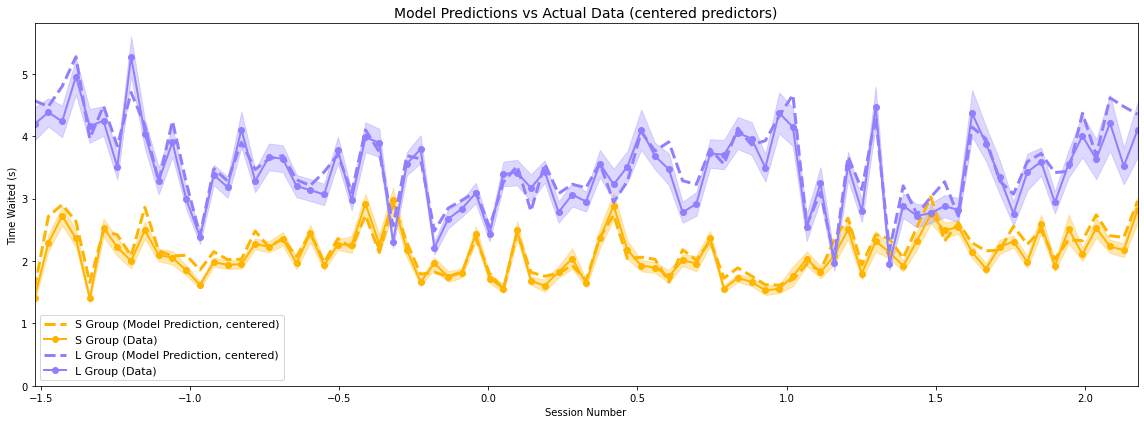

In [ ]:
session_stats = (
    df
    .groupby(['session', 'group'], as_index=False)
    .agg(
        mean_tw=('time_waited', 'mean'),
        std_tw =('time_waited', 'std'),
        count  =('time_waited', 'count')
    )
)
session_stats['se_tw'] = session_stats['std_tw'] / np.sqrt(session_stats['count'].clip(lower=1))

prediction_stats = (
    df
    .groupby(['session', 'group'], as_index=False)
    .agg(
        mean_pred=('predictions', 'mean'),
        std_pred=('predictions', 'std'),
        count_pred=('predictions', 'count')
    )
)

plt.figure(figsize=(16, 6))

for g in df['group'].unique():
    sel = prediction_stats[prediction_stats['group'] == g]
    plt.plot(
        sel['session'],
        sel['mean_pred'],
        '--', linewidth=3, color=custom_palette[g],
        label=f'{g.upper()} Group (Model Prediction, centered)'
    )

    gd = session_stats[session_stats['group'] == g]
    plt.plot(
        gd['session'], gd['mean_tw'],
        'o-', markersize=6, linewidth=2, color=custom_palette[g],
        label=f'{g.upper()} Group (Data)'
    )
    plt.fill_between(
        gd['session'],
        gd['mean_tw'] - gd['se_tw'],
        gd['mean_tw'] + gd['se_tw'],
        alpha=0.3, color=custom_palette[g]
    )
    

plt.title('Model Predictions vs Actual Data (centered predictors)', fontsize=14)
plt.xlabel('Session Number'); plt.ylabel('Time Waited (s)')
plt.legend(fontsize=11); plt.xlim(df['session'].min(), df['session'].max())
plt.ylim(bottom=0); plt.tight_layout()
plt.savefig(f'{figure_folder}/predictions_centered.png', dpi=300, bbox_inches='tight')